<a href="https://colab.research.google.com/github/Shadidi/NLP_Chatbot/blob/main/Answering_Bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# install huggingface libraries
!pip install pytorch-pretrained-bert pytorch-nlp pytorch_transformers

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import AdamW, BertForQuestionAnswering
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)
torch.cuda.empty_cache()

In [ ]:
#To run this code,
#The attached file final_project needs to be on the root directory
#of a google drive account
#Once there, the weights and required training files will load and the
#training time will just be loading the weights into the model
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
!ls /drive/My\ Drive/final_project

cache_train	  checkpoint-6000		 custom_null_odds.json
cache_validation  checkpoint-7000		 custom_predictions.json
checkpoint-1000   checkpoint-8000		 dev-v2.0.json
checkpoint-2000   checkpoint-9000		 nbest_predictions.json
checkpoint-3000   checkpoint-final		 null_odds.json
checkpoint-4000   custom_input.json		 predictions.json
checkpoint-5000   custom_nbest_predictions.json  train-v2.0.json


In [ ]:
import sys
sys.path.append('/drive/My Drive/final_project')

In [ ]:
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py'
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py'

--2021-05-05 02:55:15--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41529 (41K) [text/plain]
Saving to: ‘utils_squad.py.5’

utils_squad.py.5    100%[===================>]  40.56K  --.-KB/s    in 0.004s  

2021-05-05 02:55:15 (11.2 MB/s) - ‘utils_squad.py.5’ saved [41529/41529]

--2021-05-05 02:55:15--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response.

In [ ]:
from utils_squad import (read_squad_examples, convert_examples_to_features,
                         RawResult, write_predictions,
                         RawResultExtended, write_predictions_extended)
from utils_squad_evaluate import EVAL_OPTS, main as evaluate_on_squad, plot_pr_curve

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
input_file = '/drive/My Drive/final_project/train-v2.0.json'
examples = read_squad_examples(input_file=input_file,
                                is_training=True,
                                version_2_with_negative=True)

In [ ]:
examples[:5]

[qas_id: 56be85543aeaaa14008c9063, question_text: When did Beyonce start becoming popular?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".], start_position: 39, end_position: 42,
 qas_id: 56be85543aeaaa14008c9065, question_text: What areas did Beyonce compete in when she was growing up?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈ

In [ ]:
train_data = pd.DataFrame.from_records([vars(example) for example in examples])
train_data.head()

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",in the late 1990s,39,42,False
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",singing and dancing,28,30,False
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",2003,82,82,False
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...","Houston, Texas",22,23,False
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",late 1990s,41,42,False


In [ ]:
sample = train_data.sample(frac=1).head(1)
context = sample.doc_tokens.values
train_data[train_data.doc_tokens.values==context]

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
57323,57295afd6aef051400154d4e,Who was the original German cinematic?,"[German, cinema, dates, back, to, the, very, e...",Max Skladanowsky,16,17,False
57324,57295afd6aef051400154d4f,What types of film were produced in the Nazi era?,"[German, cinema, dates, back, to, the, very, e...",propaganda,45,45,False
57325,57295afd6aef051400154d50,Who controls film production in the GDR?,"[German, cinema, dates, back, to, the, very, e...",Deutsche Film-Aktiengesellschaft,92,93,False
57326,57295afd6aef051400154d51,When did German cinema come back internationally?,"[German, cinema, dates, back, to, the, very, e...",1960s,61,61,False
57327,5a63e8297f3c80001a150b8d,What was Max Skladanowsky active in during the...,"[German, cinema, dates, back, to, the, very, e...",,-1,-1,True
57328,5a63e8297f3c80001a150b8e,What did Murnau produce during the Nazi era?,"[German, cinema, dates, back, to, the, very, e...",,-1,-1,True
57329,5a63e8297f3c80001a150b8f,What did Leni Riefenstahl do in the 1960's?,"[German, cinema, dates, back, to, the, very, e...",,-1,-1,True
57330,5a63e8297f3c80001a150b90,Who controlled film production in West-Germany?,"[German, cinema, dates, back, to, the, very, e...",,-1,-1,True


In [ ]:
import random
def print_squad_sample(train_data, line_length=14, separator_length=120):
  sample = train_data.sample(frac=1).head(1)
  context = sample.doc_tokens.values
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = train_data[train_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.orig_answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), (answer if answer else 'No awnser found'))

In [ ]:
print_squad_sample(train_data)

CONTEXT: 
Definitions vary on the precise boundaries of the Appalachians. The United States Geological Survey
(USGS) defines the Appalachian Highlands physiographic division as consisting of thirteen provinces: the Atlantic
Coast Uplands, Eastern Newfoundland Atlantic, Maritime Acadian Highlands, Maritime Plain, Notre Dame and Mégantic
Mountains, Western Newfoundland Mountains, Piedmont, Blue Ridge, Valley and Ridge, Saint Lawrence Valley, Appalachian
Plateaus, New England province, and the Adirondack provinces. A common variant definition does not
include the Adirondack Mountains, which geologically belong to the Grenville Orogeny and have a
different geological history from the rest of the Appalachians.
QUESTION:                                                                                            ANSWER:
How many provinces are in the mountain range?                                                        thirteen provinces
What is one of the provinces?                           

In [ ]:

train_data['paragraph_len'] = train_data['doc_tokens'].apply(len)
train_data['question_len'] = train_data['question_text'].apply(len)
train_data.sample(frac=1).head(5)

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible,paragraph_len,question_len
21155,56e87ebf99e8941900975e3e,What age group has most of the population incl...,"[As, of, 2000[update],, children, and, teenage...",adults,16,16,False,32,51
101281,572f84b3a23a5019007fc6d3,When did General Wolfe take Quebec?,"[All, of, Britain's, campaigns, against, New, ...","On 13 September 1759, following a three-month ...",40,55,False,116,35
44912,5ad36009604f3c001a3fdf26,What line of low end electronics did Dell crea...,"[The, release, of, Apple's, iPad, tablet, comp...",,-1,-1,True,167,92
80248,5acd0ee707355d001abf32b8,What are character encodings implemented by?,"[Unicode, can, be, implemented, by, different,...",,-1,-1,True,102,44
88195,572bf917750c471900ed4c4e,What is monotheism?,"[In, theism,, God, is, the, creator, and, sust...",belief in the existence of one God,28,34,False,104,19


In [ ]:
max_seq_length = 256
print("Percentage of context's less than max_seq_length = %s%%" % (len([l for l in train_data['paragraph_len'] if l <= max_seq_length])/len(train_data) * 100))

Percentage of context's less than max_seq_length = 98.19289589392184%


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
doc_stride = 128
max_seq_length = 256
max_query_length = 64
# batch size of 64 if RAM available.
batch_size = 14

In [ ]:
cached_features_file = '/drive/My Drive/final_project/cache_train'

In [ ]:
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=True)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [ ]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_start_positions = torch.tensor([f.start_position for f in features], dtype=torch.long)
all_end_positions = torch.tensor([f.end_position for f in features], dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask)

In [ ]:
train_sampler = RandomSampler(dataset)
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, drop_last=True)

In [ ]:
import glob
checkpoints = sorted(glob.glob('/drive/My Drive/final_project/checkpoint*-[0-9]*'))

In [ ]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [ ]:
if len(checkpoints) > 0:
  global_step = checkpoints[-1].split('-')[-1]
  ckpt_name = '/drive/My Drive/final_project/checkpoint-{}'.format(global_step)
  print("Loading model from checkpoint %s" % ckpt_name)
  model = BertForQuestionAnswering.from_pretrained(ckpt_name)
  train_loss_set_ckpt = torch.load(ckpt_name + '/training_loss.pt')
  train_loss_set = to_list(train_loss_set_ckpt)
  tr_loss = train_loss_set[-1]
else:
  global_step = 0
  train_loss_set = []
  tr_loss = 0.0
  model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

model.cuda()

Loading model from checkpoint /drive/My Drive/final_project/checkpoint-9000


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[-1.2649e-02, -6.6199e-03, -3.1451e-03,  ...,  6.7657e-05,
         -3.6961e-02,  4.1573e-03],
        [-5.7847e-02, -2.8350e-02, -1.7493e-02,  ..., -3.5200e-02,
         -2.6129e-03,  1.4186e-02]], device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([0.0150, 0.0154], device='cuda:0', requires_grad=True))


In [ ]:
learning_rate = 5e-5
adam_epsilon=1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [ ]:
torch.cuda.empty_cache()
num_train_epochs = 1

print("***** Running training *****")
print("  Num examples = %d" % len(dataset))
print("  Num Epochs = %d" % num_train_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % (len(train_dataloader) // num_train_epochs))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")
set_seed()

global_step = int(global_step)
for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      if step < global_step + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)

      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1], 
                'token_type_ids':  batch[2],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      inputs = inputs.to(device)

      outputs = model(**inputs)

      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step += 1
    
      if global_step % 1000 == 0:
        print("Train loss: {}".format(tr_loss/global_step))
        output_dir = '/drive/My Drive/final_project/checkpoint-{}'.format(global_step)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        print("Saving training_loss.pt to %s" % os.path.join(output_dir, '/training_loss.pt'))
        torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, '/training_loss.pt'))
        print("Saving model checkpoint to %s" % output_dir)

Iteration:   3%|▎         | 318/10304 [00:00<00:03, 3178.14it/s]

***** Running training *****
  Num examples = 13600
  Num Epochs = 1
  Batch size = 14
  Total optimization steps = 10304



Epoch: 100%|██████████| 1/1 [00:03<00:00,  3.22s/it]


In [ ]:
output_dir = '/drive/My Drive/final_project/checkpoint-final'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)

In [ ]:
train_loss_set_ckpt = torch.load('/drive/My Drive/final_project/checkpoint-final/training_loss.pt')
train_loss_set = to_list(train_loss_set_ckpt)

FileNotFoundError: ignored

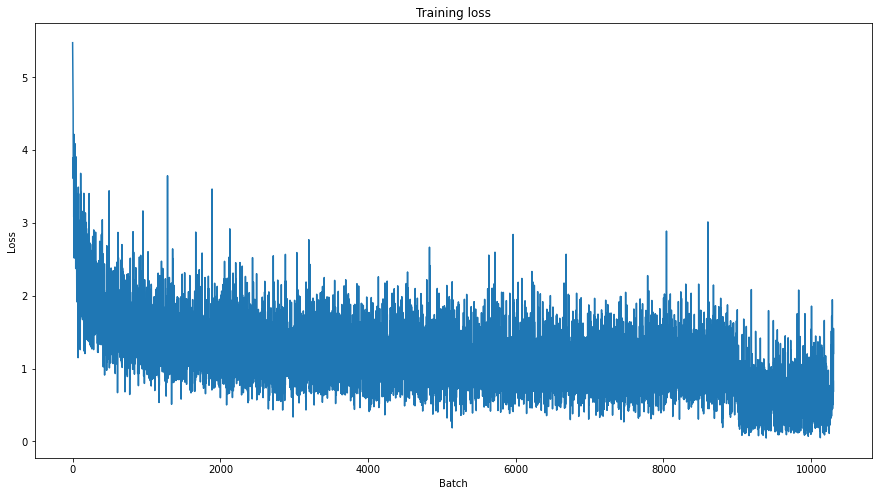

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

**Load test dataset**

In [ ]:
input_file = '/drive/My Drive/final_project/dev-v2.0.json'
val_examples = read_squad_examples(input_file=input_file,
                                is_training=False,
                                version_2_with_negative=True)
doc_stride = 128
max_seq_length = 256
max_query_length = 64
cached_features_file = '/drive/My Drive/final_project/cache_validation'

# Cache features for faster loading
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=val_examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=False)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [ ]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_example_index, all_cls_index, all_p_mask)

In [ ]:
validation_sampler = SequentialSampler(dataset)
validation_dataloader = DataLoader(dataset, sampler=validation_sampler, batch_size=batch_size, drop_last=True)

**Evaluate test dataset**

In [ ]:

def evaluate(model, tokenizer):
  print("***** Running evaluation *****")
  print("  Num examples = %d" % len(dataset))
  print("  Batch size = %d" % batch_size)
  all_results = []
  predict_file = '/drive/My Drive/final_project/dev-v2.0.json'
  for batch in tqdm(validation_dataloader, desc="Evaluating", miniters=100, mininterval=5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
      example_indices = batch[3]
      outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
      eval_feature = features[example_index.item()]
      unique_id = int(eval_feature.unique_id)

      result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
      all_results.append(result)

  # Compute predictions
  output_prediction_file = "/drive/My Drive/final_project/predictions.json"
  output_nbest_file = "/drive/My Drive/final_project/nbest_predictions.json"
  output_null_log_odds_file = "/drive/My Drive/final_project/null_odds.json"
  output_dir = "/drive/My Drive/final_project/predict_results"

  write_predictions(val_examples, features, all_results, 10,
                  30, True, output_prediction_file,
                  output_nbest_file, output_null_log_odds_file, False,
                  True, 0.0)

  # Evaluate with the official SQuAD script
  evaluate_options = EVAL_OPTS(data_file=predict_file,
                               pred_file=output_prediction_file,
                               na_prob_file=output_null_log_odds_file,
                               out_image_dir=None)
  results = evaluate_on_squad(evaluate_options)
  return results

In [ ]:
!touch "/drive/My Drive/final_project/custom_input.json"

In [ ]:
results = evaluate(model, tokenizer)

Evaluating:   0%|          | 0/971 [00:00<?, ?it/s]

***** Running evaluation *****
  Num examples = 13600
  Batch size = 14


Evaluating: 100%|██████████| 971/971 [04:23<00:00,  3.69it/s]


KeyError: ignored

In [ ]:
import json
results_json = []
for k in enumerate(results.keys()):
  result_dict = {k[1] : results[k[1]]}
  results_json.append(result_dict)
print(results_json)
with open('results.json', 'w') as f:
  json.dump(results_json, f)

NameError: ignored

**Evaluate on any text**

In [ ]:
from transformers import BertTokenizer

def getAnswerToQuestion(question,paragraph,model):

  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

  encoding = tokenizer.encode_plus(text=question,text_pair=paragraph,add_special=True)

  inputs = encoding['input_ids']
  sentence_embedding = encoding['token_type_ids']
  tokens = tokenizer.convert_ids_to_tokens(inputs)


  model = model.to(device)



  start_scores, end_scores = model(input_ids=torch.tensor([inputs], device='cuda'), token_type_ids=torch.tensor([sentence_embedding], device='cuda'))



  start_index = torch.argmax(start_scores)

  end_index = torch.argmax(end_scores)

  answer = ' '.join(tokens[start_index:end_index+1])

  corrected_answer = ''

  for word in answer.split():
      
      #If it's a subword token
      if word[0:2] == '##':
          corrected_answer += word[2:]
      else:
          corrected_answer += ' ' + word

  return corrected_answer



In [ ]:
question = '''What does Cartography study?'''

paragraph = '''Cartography studies the representation of the Earth's surface with abstract symbols (map making). Although other subdisciplines of geography rely on maps for presenting their analyses, the actual making of maps is abstract enough to be regarded separately. Cartography has grown from a collection of drafting techniques into an actual science.

Cartographers must learn cognitive psychology and ergonomics to understand which symbols convey information about the Earth most effectively, and behavioural psychology to induce the readers of their maps to act on the information. They must learn geodesy and fairly advanced mathematics to understand how the shape of the Earth affects the distortion of map symbols projected onto a flat surface for viewing. It can be said, without much controversy, that cartography is the seed from which the larger field of geography grew. Most geographers will cite a childhood fascination with maps as an early sign they would end up in the field.''' 

print(getAnswerToQuestion(question,paragraph,model))

Keyword arguments {'add_special': True} not recognized.
Keyword arguments {'add_special': True} not recognized.


 the representation of the earth ' s surface with abstract symbols


Code was heavily inspired by the following blog-post: https://towardsdatascience.com/bert-nlp-how-to-build-a-question-answering-bot-98b1d1594d7b